<a href="https://colab.research.google.com/github/Joshuahuang55/Machine-Learning-Green-trademark/blob/main/%E7%B6%A0%E8%89%B2%E5%95%86%E6%A8%99%E6%AC%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

## Goal


利用商標權的文字描述資料搭配人工判讀"綠色"的方法來訓練機器辨別綠色商標權

# Data Description and Pre-processing

## Data Source

資料來自美國智慧財產局USPTO裡面商標的statement以及case_file文件
連結:
https://bulkdata.uspto.gov/data/trademark/casefile/economics/2020/

## Exploratory Data Analysis and Feature Engineering

### Package

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import nltk
import sklearn
nltk.download("popular")
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RandomizedSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix,f1_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer
    )
# Load libraries

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm

import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.offline as py
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import nltk
from wordcloud import WordCloud

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

### Download Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_excel('/content/drive/My Drive/統計學習期末/green_trademark_label.xlsx')
df=df[["Green_TM_Label","statement_text"]]
df=df.dropna()
df=df.rename(columns={'Green_TM_Label': 'label'}) 
df["category"]=df['label']
map_dict = {1: "Green", 0:"non_Green"}
df['category'].replace(map_dict, inplace=True)

df.head(10)

,label,statement_text,category
0,0.0,"Electrical and electronic circuits, components...",non_Green
1,0.0,"Electrical and electronic circuits, components...",non_Green
2,0.0,Electrical and electronic circuits for active ...,non_Green
3,0.0,"Electrical and electronic circuits, electrical...",non_Green
4,0.0,"Housewares, namely, bowls, cups, dishes, heat-...",non_Green
5,0.0,"Housewares, namely, bowls, cake servers, cooki...",non_Green
6,0.0,Administration of holiday and vacation club ac...,non_Green
7,0.0,"Maintenance, repair and updating of computer s...",non_Green
8,0.0,Brake pads for vehicles,non_Green
9,1.0,Refrigerator condensing units and sealed units...,Green


### Summary Statistic

透過Histogram觀察標註出來的綠色或是非綠色商標權的數量

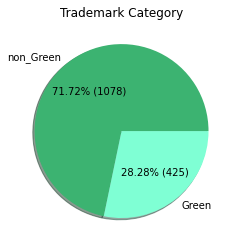

In [ ]:
values=[1078, 425]             
labels=['non_Green', 'Green'] 
colors=['mediumseagreen','aquamarine'] 

def make_autopct(values):
  def my_autopct(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{p:.2f}% ({v:d})'.format(p=pct, v=val)
  return my_autopct


plt.pie(values, autopct=make_autopct(values), labels=labels, colors=colors, shadow=True)
plt.title('Trademark Category')
plt.show()

In [ ]:
df[['category']].describe()

,category
count,1503
unique,2
top,non_Green
freq,1078


透過長條圖可以觀察到大部分的敘述長度位於0-200之間，儘管還是有一些特別長的敘述。

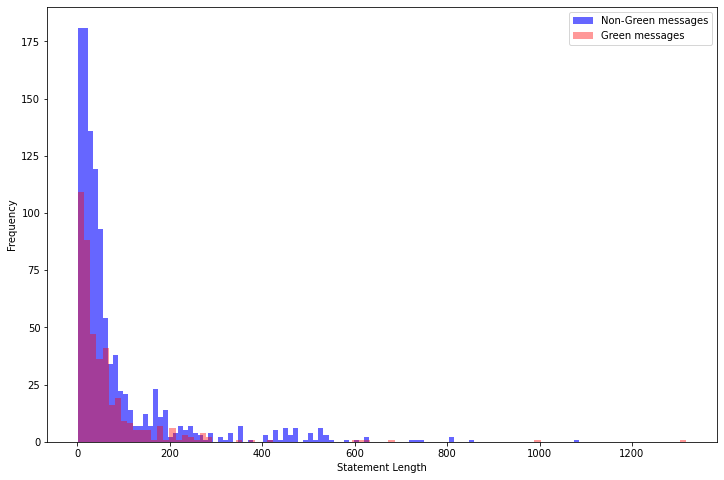

In [ ]:
df['word_length'] = df['statement_text'].apply(lambda x:len(x.split()))
plt.figure(figsize=(12, 8))

df[df.label==0].word_length.plot(bins=100, kind='hist', color='blue', 
                                       label='Non-Green messages', alpha=0.6)
df[df.label==1].word_length.plot(bins=100,kind='hist', color='red', 
                                       label='Green messages', alpha=0.4)
plt.legend()
plt.xlabel("Statement Length")
plt.show()

     |████████████████████████████████| 115 kB 5.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



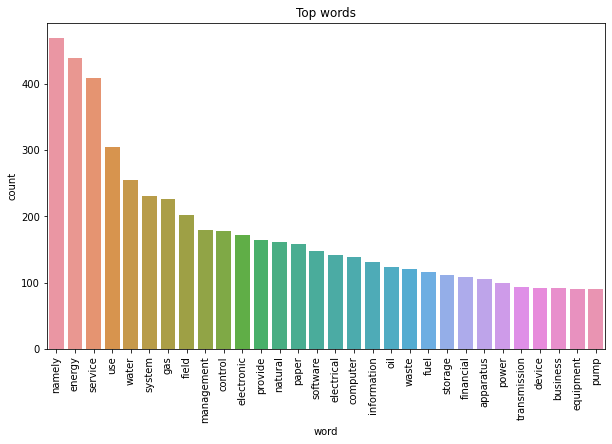

In [ ]:
!pip install text-hammer
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
#     df[column] = df[column].progress_apply(lambda x:th.spelling_correction(x))
  
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

cleaned_df = text_preprocessing(df[df.label==1], "statement_text")

import nltk

### Calculating the word frequency by using nltk
words_list = []
for sentence in cleaned_df.statement_text:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)
# freq_dist.keys()

temp = pd.DataFrame(freq_dist.most_common(30),  columns=['word', 'count'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=temp, ax=ax)
plt.title("Top words")
plt.xticks(rotation='vertical');

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



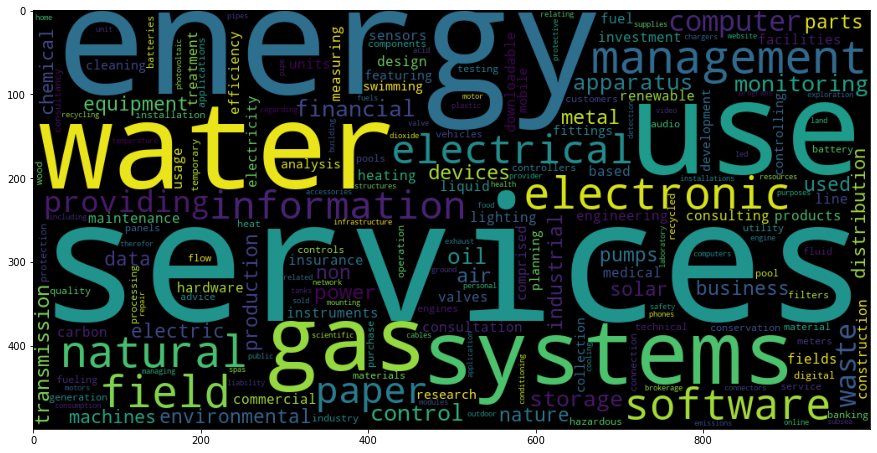

In [ ]:
import collections
from sklearn.feature_extraction.text import CountVectorizer

g_subset = df[df['category']=='Green']
ng_subset = df[df['category']=='non_Green']
vectorizer_rmsw = CountVectorizer(stop_words="english")

## for green subset
text = []
for i in g_subset['statement_text']:
  text.append(i)

text_str = ''.join(text)
text_1=text_str.replace(',',' ')
text_1=text_1.replace(';',' ')
text_list = text_1.split() 

stop_word = vectorizer_rmsw.fit_transform(text_list)
stop_word = stop_word.toarray()
stop_word = pd.DataFrame(data=stop_word,columns = vectorizer_rmsw.get_feature_names())

word_could_dict = dict(stop_word.sum(axis = 0, skipna = True))
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

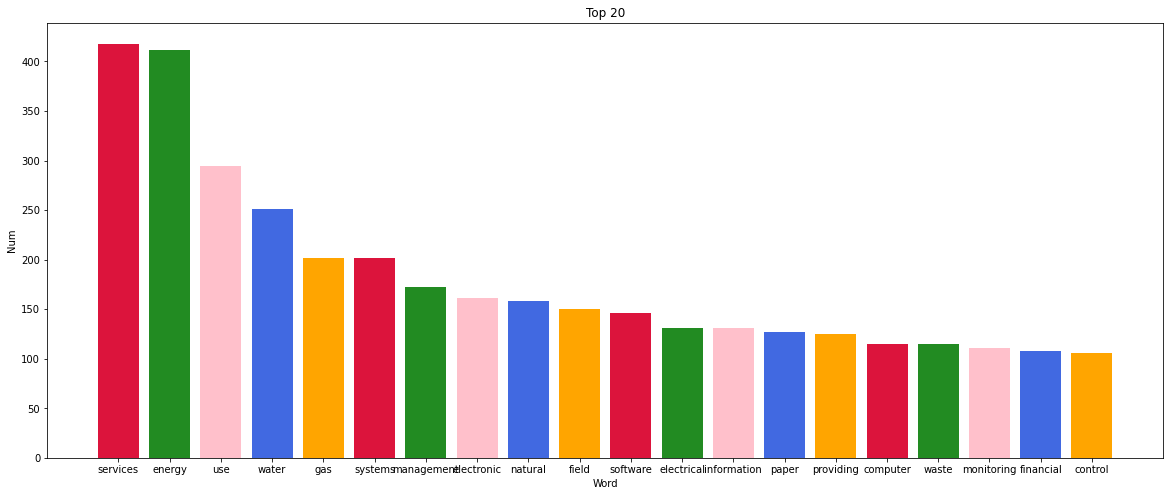

In [ ]:
# top 20 word list
word_could_dict = dict(sorted(word_could_dict.items(), key=lambda item: item[1], reverse = True))
name = list(word_could_dict.keys())[0:20] 
num = list(word_could_dict.values())[0:20] 
x = np.arange(len(name))
plt.figure(figsize=(20,8))
plt.bar(x, num, color=['crimson','forestgreen','pink','royalblue','orange'])
plt.xticks(x, name)
plt.xlabel('Word')
plt.ylabel('Num')
plt.title('Top 20')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



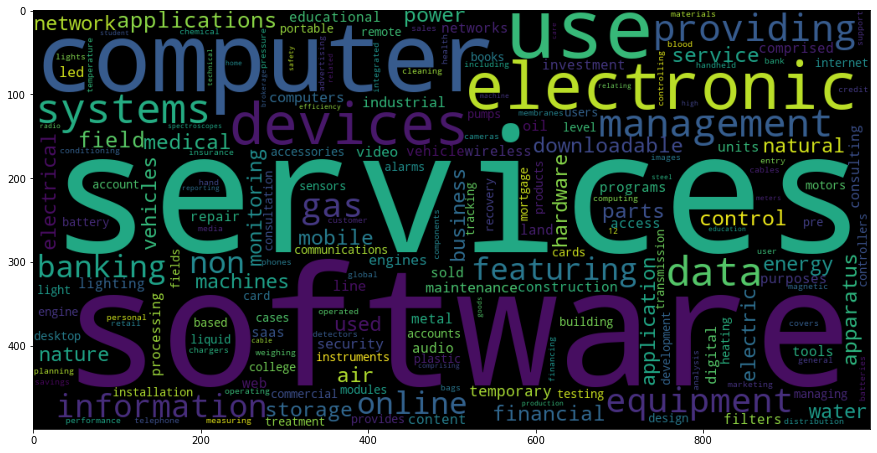

In [ ]:
## for non_green subset
text = []
for i in ng_subset['statement_text']:
  text.append(i)

text_str = ''.join(text)
text_1=text_str.replace(',',' ')
text_1=text_1.replace(';',' ')
text_list = text_1.split() 

stop_word = vectorizer_rmsw.fit_transform(text_list)
stop_word = stop_word.toarray()
stop_word = pd.DataFrame(data=stop_word,columns = vectorizer_rmsw.get_feature_names())

word_could_dict = dict(stop_word.sum(axis = 0, skipna = True))

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

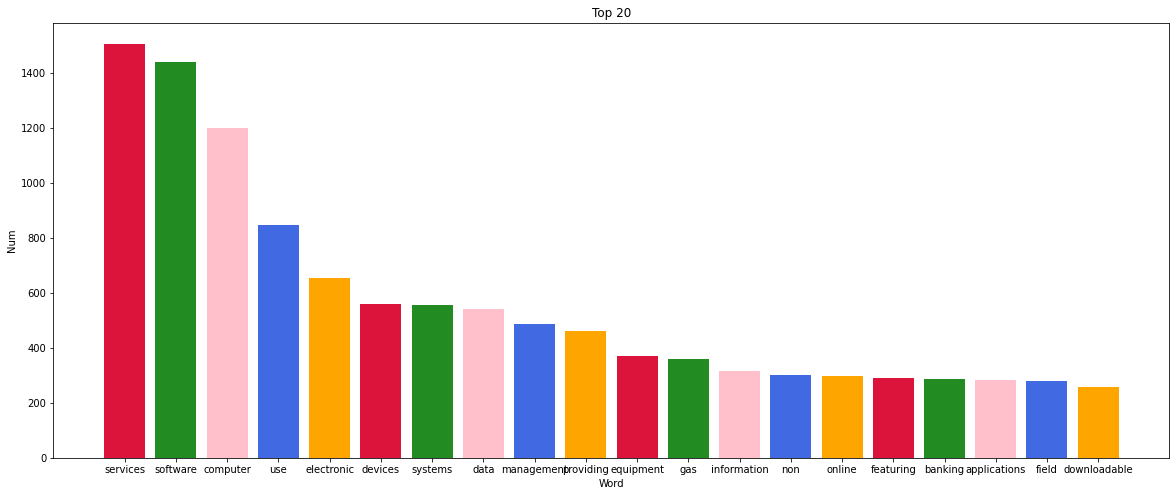

In [ ]:
# top 20 word list
word_could_dict = dict(sorted(word_could_dict.items(), key=lambda item: item[1], reverse = True))
name = list(word_could_dict.keys())[0:20] 
num = list(word_could_dict.values())[0:20] 
x = np.arange(len(name))
plt.figure(figsize=(20,8))
plt.bar(x, num, color=['crimson','forestgreen','pink','royalblue','orange'])
plt.xticks(x, name)
plt.xlabel('Word')
plt.ylabel('Num')
plt.title('Top 20')
plt.show()

使用長條圖去觀察敘述句子的長度

In [ ]:
df['length'] = df['statement_text'].apply(len)
df.head()

,label,statement_text,category,word_length,length
0,0.0,"Electrical and electronic circuits, components...",non_Green,59,496
1,0.0,"Electrical and electronic circuits, components...",non_Green,59,496
2,0.0,Electrical and electronic circuits for active ...,non_Green,70,588
3,0.0,"Electrical and electronic circuits, electrical...",non_Green,61,535
4,0.0,"Housewares, namely, bowls, cups, dishes, heat-...",non_Green,53,385


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



[Text(0, 0.5, 'Count'), Text(0.5, 0, 'length')]

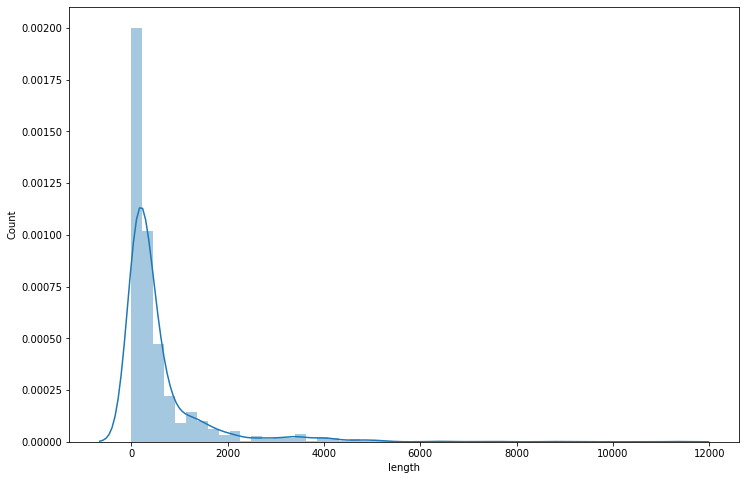

In [ ]:
df['length'] = df['statement_text'].apply(len)
plt.figure(figsize=(12,8))
length = sns.distplot(x=df['length'])
length.set(xlabel='length', ylabel='Count')

# Feature Engineering

清理文字資料

In [5]:
def preprocess(text):
    # Remove stopwords
    stopwords_list = stopwords.words('english')
    words = [i for i in text.split() if i.lower() not in stopwords_list]
    text_1 = ' '.join(words)
    # Remove puctuation and replace with a space.
    punc_string = string.punctuation
    text_2 = text_1.translate(str.maketrans(punc_string, len(punc_string)*' '))
    words_1 = text_2.split()
    # Perform word stemming 
    stemmer = SnowballStemmer('english')
    words_2 = [stemmer.stem(word) for word in words_1]
    text_3 = ' '.join(words_2)
    return text_3

In [6]:
#處理文字
nltk.download('stopwords')
df["statement_text"] = df["statement_text"].apply(preprocess)
df["statement_text"] = df["statement_text"].apply(preprocess)
df_train, df_test = train_test_split(df, stratify=df["label"],test_size=0.2,random_state=22)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


字根化的文字雲

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



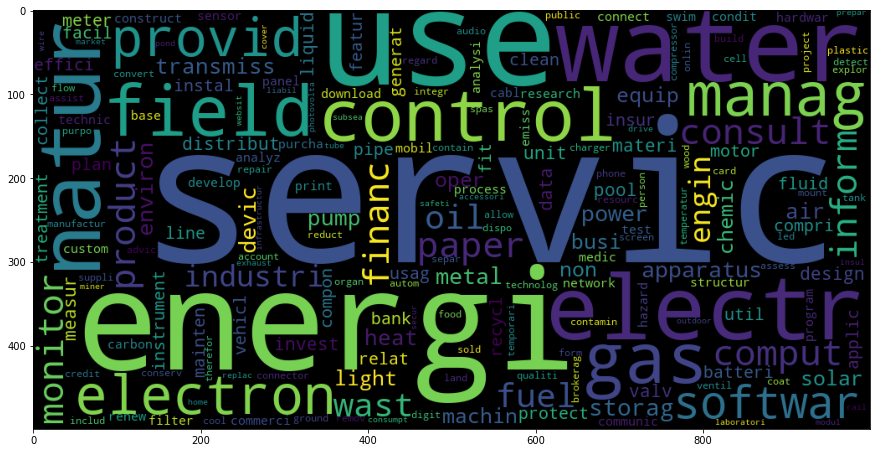

In [ ]:
import collections
from sklearn.feature_extraction.text import CountVectorizer

g_subset = df[df['category']=='Green']
ng_subset = df[df['category']=='non_Green']
vectorizer_rmsw = CountVectorizer(stop_words="english")

## for green subset
text = []
for i in g_subset['statement_text']:
  text.append(i)

text_str = ''.join(text)
text_1=text_str.replace(',',' ')
text_1=text_1.replace(';',' ')
text_list = text_1.split() 

stop_word = vectorizer_rmsw.fit_transform(text_list)
stop_word = stop_word.toarray()
stop_word = pd.DataFrame(data=stop_word,columns = vectorizer_rmsw.get_feature_names())

word_could_dict = dict(stop_word.sum(axis = 0, skipna = True))
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

字根化的長條圖

  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



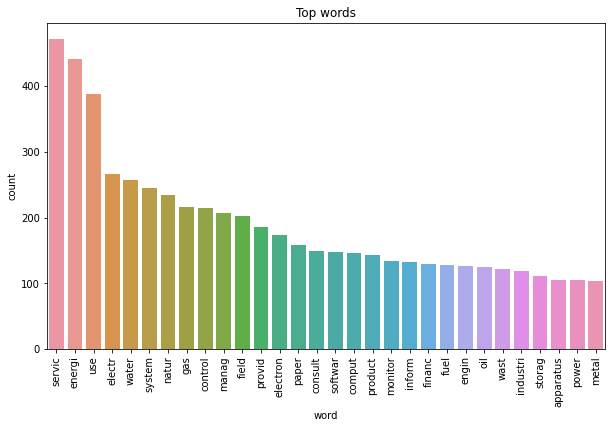

In [ ]:
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

cleaned_df = text_preprocessing(df[df.label==1], "statement_text")

import nltk

### Calculating the word frequency by using nltk
words_list = []
for sentence in cleaned_df.statement_text:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)
# freq_dist.keys()

temp = pd.DataFrame(freq_dist.most_common(30),  columns=['word', 'count'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=temp, ax=ax)
plt.title("Top words")
plt.xticks(rotation='vertical');

定義 function

In [8]:
def get_ngrams(text, n ):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

def generate_key_list(df_train , size_table=200,ignore=3):
    dict_green_raw = dict()
    dict_non_green_raw = dict()
    dict_IDF_green = dict()# ignore all other than letters.
    dict_IDF_non_green = dict()# ignore all other than letters.
    
    finds_green = df_train[df_train['label'] == 1.0]["statement_text"].apply(len)
    finds_non_green = df_train[df_train['label'] == 0.0]["statement_text"].apply(len)
    green_word_num = sum(pd.DataFrame(finds_green)["statement_text"])
    non_green_word_num = sum(pd.DataFrame(finds_non_green)["statement_text"])

    for i in range(df_train.shape[0]):
        finds = re.findall('[A-Za-z]+', df_train.iloc[i]["statement_text"])
        if df_train.iloc[i].label == 1.0:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower() #英文轉成小寫
                try:
                    dict_green_raw[find] = dict_green_raw[find] + 1
                except: 
                    dict_green_raw[find] = dict_green_raw.get(find,1)
                    dict_non_green_raw[find] =  dict_non_green_raw.get(find,0)
        else:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower()
                try:
                    dict_non_green_raw[find] = dict_non_green_raw[find] + 1
                except: 
                    dict_non_green_raw[find] = dict_non_green_raw.get(find,1)
                    dict_green_raw[find] = dict_green_raw.get(find,0)
  

        if df_train.iloc[i].label == 1.0:
          word_set_green = set()
          for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set_green):
                try:
                    dict_IDF_green[find] = dict_IDF_green[find] + 1
                except: 
                    dict_IDF_green[find] = dict_IDF_green.get(find,1)
                    dict_IDF_non_green[find] =  dict_IDF_non_green.get(find,0)

            word_set_green.add(find)
        else:
          word_set_non_green = set()
          for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set_non_green):
                try:
                    dict_IDF_non_green[find] = dict_IDF_non_green[find] + 1
                except: 
                    dict_IDF_non_green[find] = dict_IDF_non_green.get(find,1)
                    dict_IDF_green[find] =  dict_IDF_green.get(find,0)
     
            word_set_non_green.add(find)

    word_df = pd.DataFrame(list(zip(dict_non_green_raw.keys(),dict_non_green_raw.values(),dict_green_raw.values(),dict_IDF_green.values(),dict_IDF_non_green.values())))
    word_df.columns = ['keyword','non_green','green','IDF_green','IDF_non_green']
    word_df['non_green'] = word_df['non_green'].astype('float')/df_train[df_train['category']=="non_Green"].shape[0]
    word_df['green'] = word_df['green'].astype('float')/df_train[df_train['category']=="Green"].shape[0]
    word_df['IDF_green'] = np.log10(green_word_num/(1+word_df['IDF_green'].astype('float'))) #詞總數/詞t在多少文件出現過
    word_df['IDF_non_green'] = np.log10(non_green_word_num/(1+word_df['IDF_non_green'].astype('float'))) #詞總數/詞t在多少文件出現過
    word_df['no_green_IDF'] = word_df['non_green']*word_df['IDF_non_green']  
    word_df['green_IDF'] = word_df['green']*word_df['IDF_green']
    word_df['diff']=word_df['green_IDF']-word_df['no_green_IDF']
    selected_green_key = word_df.sort_values('diff',ascending=False)  
    keyword_dict = dict()
    
    i = 0
    for word in selected_green_key.head(size_table).keyword:
        keyword_dict.update({word.strip():i})
        i+=1
    return keyword_dict   

def convert_Content(content, keyword_dict):
	m = len(keyword_dict)
	res = np.int_(np.zeros(m))
	finds = re.findall('[A-Za-z]+', content)
	for find in finds:
		find=find.lower()
		try:
			i = keyword_dict[find]
			res[i]=1
		except:
			continue
	return res

def raw2feature(df_train,df_test,keyword_dict):
    n_train = df_train.shape[0]
    n_test = df_test.shape[0]
    m = len(keyword_dict)
    X_train = np.zeros((n_train,m));
    X_test = np.zeros((n_test,m));
    Y_train = np.int_(df_train.label==1)
    Y_test = np.int_(df_test.label==1)
    for i in range(n_train):
        X_train[i,:] = convert_Content(df_train.iloc[i]["statement_text"], keyword_dict)
    for i in range(n_test):
        X_test[i,:] = convert_Content(df_test.iloc[i]["statement_text"], keyword_dict)
        
    return [X_train,Y_train],[X_test,Y_test]




檢視關鍵的重要詞 - Unigram

In [10]:
# build a tabu list based on the training data
size_table = 400                # how many features are used to classify spam
word_len_ignored = 3           # ignore those words shorter than this variable
keyword_dict=generate_key_list(df_train ,size_table, word_len_ignored)

In [11]:
sorted(keyword_dict.items(), key=lambda x:x[1])[0:400]

[('energi', 0),
 ('water', 1),
 ('paper', 2),
 ('wast', 3),
 ('fuel', 4),
 ('environ', 5),
 ('electr', 6),
 ('metal', 7),
 ('product', 8),
 ('recycl', 9),
 ('pool', 10),
 ('valv', 11),
 ('control', 12),
 ('transmiss', 13),
 ('solar', 14),
 ('natur', 15),
 ('gas', 16),
 ('chemic', 17),
 ('renew', 18),
 ('oil', 19),
 ('emiss', 20),
 ('pump', 21),
 ('heat', 22),
 ('hazard', 23),
 ('apparatus', 24),
 ('monitor', 25),
 ('distribut', 26),
 ('effici', 27),
 ('usag', 28),
 ('materi', 29),
 ('wood', 30),
 ('fit', 31),
 ('spas', 32),
 ('carbon', 33),
 ('industri', 34),
 ('reduct', 35),
 ('contamin', 36),
 ('conserv', 37),
 ('qualiti', 38),
 ('swim', 39),
 ('treatment', 40),
 ('fluid', 41),
 ('rail', 42),
 ('pipe', 43),
 ('subsea', 44),
 ('pond', 45),
 ('signag', 46),
 ('facil', 47),
 ('generat', 48),
 ('collector', 49),
 ('flow', 50),
 ('pulp', 51),
 ('clean', 52),
 ('research', 53),
 ('field', 54),
 ('consult', 55),
 ('made', 56),
 ('ground', 57),
 ('purcha', 58),
 ('satur', 59),
 ('solvent', 6

將前20大重要字畫出來

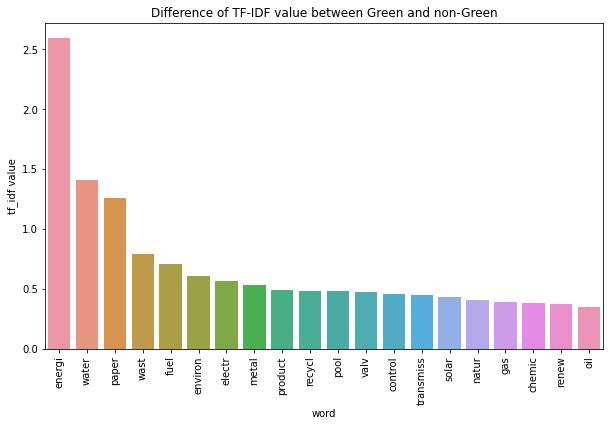

In [9]:
def generate_value_list(df_train , size_table=200,ignore=3):
    dict_green_raw = dict()
    dict_non_green_raw = dict()
    dict_IDF_green = dict()# ignore all other than letters.
    dict_IDF_non_green = dict()# ignore all other than letters.
    
    finds_green = df_train[df_train['label'] == 1.0]["statement_text"].apply(len)
    finds_non_green = df_train[df_train['label'] == 0.0]["statement_text"].apply(len)
    green_word_num = sum(pd.DataFrame(finds_green)["statement_text"])
    non_green_word_num = sum(pd.DataFrame(finds_non_green)["statement_text"])

    for i in range(df_train.shape[0]):
        finds = re.findall('[A-Za-z]+', df_train.iloc[i]["statement_text"])
        if df_train.iloc[i].label == 1.0:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower() #英文轉成小寫
                try:
                    dict_green_raw[find] = dict_green_raw[find] + 1
                except: 
                    dict_green_raw[find] = dict_green_raw.get(find,1)
                    dict_non_green_raw[find] =  dict_non_green_raw.get(find,0)
        else:
            for find in finds:
                if len(find)<ignore: continue
                find = find.lower()
                try:
                    dict_non_green_raw[find] = dict_non_green_raw[find] + 1
                except: 
                    dict_non_green_raw[find] = dict_non_green_raw.get(find,1)
                    dict_green_raw[find] = dict_green_raw.get(find,0)
  

        if df_train.iloc[i].label == 1.0:
          word_set_green = set()
          for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set_green):
                try:
                    dict_IDF_green[find] = dict_IDF_green[find] + 1
                except: 
                    dict_IDF_green[find] = dict_IDF_green.get(find,1)
                    dict_IDF_non_green[find] =  dict_IDF_non_green.get(find,0)

            word_set_green.add(find)
        else:
          word_set_non_green = set()
          for find in finds:
            if len(find)<ignore: continue
            find = find.lower()
            if not(find in word_set_non_green):
                try:
                    dict_IDF_non_green[find] = dict_IDF_non_green[find] + 1
                except: 
                    dict_IDF_non_green[find] = dict_IDF_non_green.get(find,1)
                    dict_IDF_green[find] =  dict_IDF_green.get(find,0)
     
            word_set_non_green.add(find)

    word_df = pd.DataFrame(list(zip(dict_non_green_raw.keys(),dict_non_green_raw.values(),dict_green_raw.values(),dict_IDF_green.values(),dict_IDF_non_green.values())))
    word_df.columns = ['keyword','non_green','green','IDF_green','IDF_non_green']
    word_df['non_green'] = word_df['non_green'].astype('float')/df_train[df_train['category']=="non_Green"].shape[0]
    word_df['green'] = word_df['green'].astype('float')/df_train[df_train['category']=="Green"].shape[0]
    word_df['IDF_green'] = np.log10(green_word_num/(1+word_df['IDF_green'].astype('float'))) #詞總數/詞t在多少文件出現過
    word_df['IDF_non_green'] = np.log10(non_green_word_num/(1+word_df['IDF_non_green'].astype('float'))) #詞總數/詞t在多少文件出現過
    word_df['no_green_IDF'] = word_df['non_green']*word_df['IDF_non_green']  
    word_df['green_IDF'] = word_df['green']*word_df['IDF_green']
    word_df['diff']=word_df['green_IDF']-word_df['no_green_IDF']
    selected_green_key = word_df.sort_values('diff',ascending=False)
    return selected_green_key




keyword_value_dict=generate_value_list(df_train ,size_table, word_len_ignored)
keyword_value_dict.sort_values(by=['diff'])
keyword = list(keyword_value_dict["keyword"])
value = list(keyword_value_dict["diff"])
tf_idf_value = dict(zip(keyword, value))

import operator

tf_idf_value = dict(sorted(tf_idf_value.items(), key=operator.itemgetter(1),reverse=True))
temp = pd.DataFrame(list(tf_idf_value.items()),columns=['word', 'tf_idf value'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='tf_idf value', data=temp.head(20), ax=ax)
plt.title("Difference of TF-IDF value between Green and non-Green")
plt.xticks(rotation='vertical');

# Modeling and Inference (Green TF-IDF Method)

將前面篩選出來的特徵關鍵字(400個字)套在training data跟testing data進而將文字資料轉成向量

In [12]:
Train_gram,Test_gram=raw2feature(df_train,df_test,keyword_dict)
X_train_gram = Train_gram[0]
X_train_gram = pd.DataFrame(X_train_gram)
X_train_gram.columns = keyword_dict.keys()

Y_train = Train_gram[1] 

X_test_gram = Test_gram[0]
X_test_gram = pd.DataFrame(X_test_gram)
X_test_gram.columns = keyword_dict.keys()

Y_test = Test_gram[1]


Y_train_df = pd.DataFrame(Y_train)
Y_train_df.columns=['label']


X_train = X_train_gram
X_test = X_test_gram

## 先把Grid Search 的 function 寫好

In [13]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

## Logistic Regression (Add Noise)(Lasso)

In [ ]:
import random 
random.seed(7)
X_train_noise = X_train
X_test_noise = X_test

noise_train = [random.randint(0, 1) for i in range(len(X_train_noise['energi']))]
X_train_noise["noise"] = noise_train

noise_test = [random.randint(0, 1) for i in range(len(X_test_noise['energi']))]
X_test_noise["noise"] = noise_test

In [ ]:
random.seed(318)
X_train_noise_2 = X_train_noise
X_test_noise_2 = X_test_noise

noise_train = [random.randint(0, 1) for i in range(len(X_train_noise_2['energi']))]
X_train_noise["noise_2"] = noise_train

noise_test = [random.randint(0, 1) for i in range(len(X_test_noise_2['energi']))]
X_test_noise["noise_2"] = noise_test

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(
    penalty="l1",
    solver="liblinear",
        tol=1e-6,
    max_iter=int(1e6),
    intercept_scaling=10000.0,
 cv=5)
clf.fit(X_train_noise, Y_train)
clf.C_  # optimal lambda: 0.35938137
clf.coef_

array([[ 1.95510159e+00, -6.63947699e-01, -1.81564956e-01,
         1.34474209e+00,  6.65144679e-01, -5.47598513e-01,
         2.83129701e-01,  1.40948536e-01, -3.51562255e-01,
         1.44305861e+00,  0.00000000e+00, -5.06905608e-01,
        -8.22248546e-01,  1.52278318e+00,  2.25477343e+00,
         3.38001562e-01,  2.55744092e-02,  0.00000000e+00,
         8.74476650e-01,  1.18254567e+00,  0.00000000e+00,
        -3.65482846e-01, -2.40126587e-01,  0.00000000e+00,
         6.84301047e-01,  1.47271860e-01,  0.00000000e+00,
        -7.59750501e-01,  6.74745095e-01,  6.81256002e-01,
         0.00000000e+00,  7.30044916e-02,  2.67479063e-01,
         0.00000000e+00, -2.03732402e-01,  6.38217538e-01,
        -8.02079010e-01,  1.14694340e+00,  0.00000000e+00,
         0.00000000e+00, -4.77823528e-02,  6.97824847e-01,
         1.70687387e+00, -5.33752108e-01,  5.94470401e-01,
         0.00000000e+00,  5.86048890e-04,  5.08128516e-01,
        -3.68131819e-01,  1.38131471e+00, -4.42244976e-0

In [ ]:
# find非負feature
all_coef = list(X_train_noise.columns)
not_zero_coef = []
for i in range(len(clf.coef_[0])):
  if clf.coef_[0][i] != 0:
    not_zero_coef.append(all_coef[i])
print(not_zero_coef)

['energi', 'water', 'paper', 'wast', 'fuel', 'environ', 'electr', 'metal', 'product', 'recycl', 'valv', 'control', 'transmiss', 'solar', 'natur', 'gas', 'renew', 'oil', 'pump', 'heat', 'apparatus', 'monitor', 'effici', 'usag', 'materi', 'fit', 'spas', 'industri', 'reduct', 'contamin', 'conserv', 'treatment', 'fluid', 'rail', 'pipe', 'subsea', 'signag', 'facil', 'generat', 'collector', 'flow', 'pulp', 'research', 'field', 'consult', 'made', 'ground', 'purcha', 'solvent', 'coal', 'meter', 'aquarium', 'paramet', 'panel', 'measur', 'reagent', 'substanc', 'screen', 'greenhous', 'indoor', 'consumpt', 'liquid', 'detect', 'project', 'remov', 'dispo', 'newsprint', 'wearabl', 'vapor', 'miner', 'coupl', 'conduit', 'spray', 'remedi', 'pellet', 'landfil', 'photovolta', 'collect', 'particul', 'convert', 'instrument', 'lamin', 'tobacco', 'soil', 'servo', 'catalyt', 'rooftop', 'analyz', 'conscious', 'cost', 'connector', 'stabil', 'irrig', 'reduc', 'caviti', 'residenti', 'aqueous', 'sulfur', 'oxygen', 

In [ ]:
clf.C_

array([2.7825594])

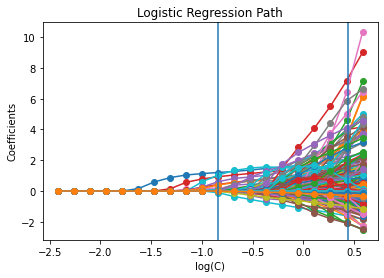

In [ ]:
from sklearn.svm import l1_min_c
# sklearn.svm.l1_min_c返回C的最小邊界值，使得對於（l1_min_c, infinity）中的每個C，模型都能保證不為空
# numpy.logspace(start, stop, num=50, endpoint=True, base=10.0)
cs = l1_min_c(X_train_noise, Y_train, loss="log") * np.logspace(0, 3, 20)
clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X_train_noise, Y_train)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker="o")
plt.axvline(np.log10(cs[10]))
plt.axvline(np.log10(2.7825))
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [ ]:
coefs_[10]

array([ 1.20348562e+00,  0.00000000e+00,  0.00000000e+00,  9.32173371e-01,
        1.46111780e-01,  0.00000000e+00,  1.99395893e-01,  0.00000000e+00,
        0.00000000e+00,  1.04339449e+00,  0.00000000e+00,  0.00000000e+00,
       -1.59415169e-04,  4.28297276e-01,  6.09951051e-01,  7.51942348e-03,
        1.42108826e-01,  0.00000000e+00,  0.00000000e+00,  7.99866780e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.12979478e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.91999705e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [ ]:
model_logis = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)

In [ ]:
model_logis.set_params(C=cs[10])
model_logis.fit(X_train_noise,Y_train)
model_logis.coef_

array([[ 1.20348673e+00,  0.00000000e+00,  0.00000000e+00,
         9.32171309e-01,  1.46112336e-01,  0.00000000e+00,
         1.99395589e-01,  0.00000000e+00,  0.00000000e+00,
         1.04339515e+00,  0.00000000e+00,  0.00000000e+00,
        -1.59970135e-04,  4.28298481e-01,  6.09952665e-01,
         7.52254740e-03,  1.42098522e-01,  0.00000000e+00,
         0.00000000e+00,  7.99939453e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.12978858e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.92001512e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [ ]:
# find非負feature
all_coef = list(X_train_noise.columns)
not_zero_coef = []
for i in range(len(model_logis.coef_[0])):
  if model_logis.coef_[0][i] != 0:
    not_zero_coef.append(all_coef[i])
print(not_zero_coef)

['energi', 'wast', 'fuel', 'electr', 'recycl', 'control', 'transmiss', 'solar', 'natur', 'gas', 'oil', 'materi', 'fluid', 'ground', 'liquid', 'storag']


In [ ]:
Prediction_LR = model_logis.predict(X_test_noise)
print('Accuracy : {:.5f}'.format(model_logis.score(X_test_noise, Y_test)))

Accuracy : 0.72757


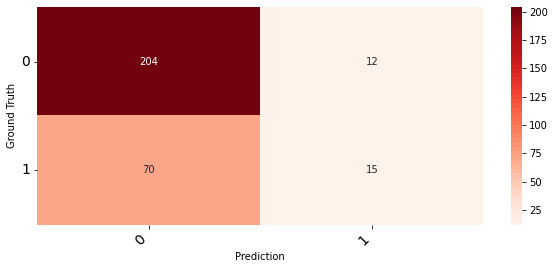

Accuray: 72.757%
ROC-AUC: 0.56046
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       216
           1       0.56      0.18      0.27        85

    accuracy                           0.73       301
   macro avg       0.65      0.56      0.55       301
weighted avg       0.69      0.73      0.67       301



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_LR)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_LR), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_LR), 5)}""")
print(classification_report(Y_test, Prediction_LR))

result = classification_report(Y_test, Prediction_LR)

## SVM

In [ ]:
Y_train_svm = np.where(Y_train <= 0.5, -1, 1)
Y_test_svm = np.where(Y_test <= 0.5, -1, 1)
model_svm = svm.SVC()
kenel=['rbf', 'poly', 'sigmoid']
C=[0.1,1, 10, 100]
gamma=[1,0.1,0.01,0.001]
parameters=dict(kernel=kenel,C=C,gamma=gamma)
svm_GridSearch = GridSearch(X_train,Y_train_svm,model_svm,parameters)
Prediction_svm = svm_GridSearch.BestModelPridict(X_test)

Best: 0.821977 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


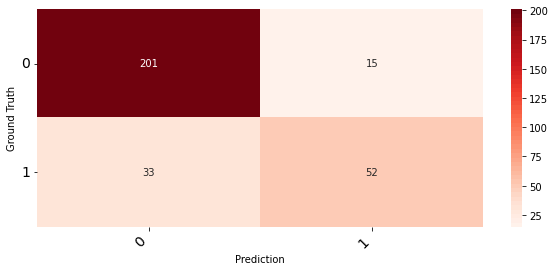

Accuray: 84.053%
ROC-AUC: 0.77116
              precision    recall  f1-score   support

          -1       0.86      0.93      0.89       216
           1       0.78      0.61      0.68        85

    accuracy                           0.84       301
   macro avg       0.82      0.77      0.79       301
weighted avg       0.84      0.84      0.83       301



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test_svm, Prediction_svm)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test_svm, Prediction_svm), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test_svm, Prediction_svm), 5)}""")
print(classification_report(Y_test_svm, Prediction_svm))

## Random Forest(Add noise)

In [ ]:
import random 
random.seed(7)
X_train_noise = X_train
X_test_noise = X_test

noise_train = [random.randint(0, 1) for i in range(len(X_train_noise['energi']))]
X_train_noise["noise"] = noise_train

noise_test = [random.randint(0, 1) for i in range(len(X_test_noise['energi']))]
X_test_noise["noise"] = noise_test

In [ ]:
random.seed(318)
X_train_noise_2 = X_train_noise
X_test_noise_2 = X_test_noise

noise_train = [random.randint(0, 1) for i in range(len(X_train_noise_2['energi']))]
X_train_noise["noise_2"] = noise_train

noise_test = [random.randint(0, 1) for i in range(len(X_test_noise_2['energi']))]
X_test_noise["noise_2"] = noise_test

In [ ]:
import numpy as np 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [24,26,28]
# Minimum number of samples required to split a node
min_samples_split = [7,8,9]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.metrics import accuracy_score
import random
random.seed(7)
model_RF = RandomForestClassifier(random_state=123)
RF_GridSearch = GridSearch(X_train_noise,Y_train,model_RF,param_grid)
Prediction_RF = RF_GridSearch.BestModelPridict(X_test_noise)

Best: 0.815296 using {'bootstrap': False, 'max_depth': 24, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 25}


In [ ]:
model_RF = RandomForestClassifier(random_state=123, n_estimators=25, max_features=0.5, max_depth=24, min_samples_split=7, min_samples_leaf=1 ,bootstrap=False )
model_RF = model_RF.fit(X_train_noise, Y_train)

In [ ]:
feature_importance = model_RF.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

print(list(X_train_noise_2.columns[sorted_idx]).index("noise"))
print(list(X_train_noise_2.columns[sorted_idx]).index("noise_2"))

382
373


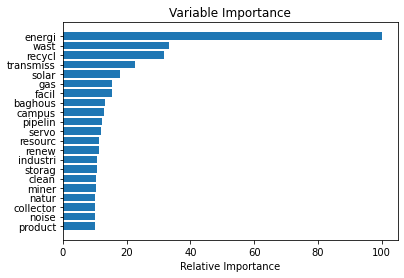

In [ ]:
pos = np.arange(sorted_idx[381:402] .shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx][381:402], align='center')
plt.yticks(pos, X_train.columns[sorted_idx][381:402])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

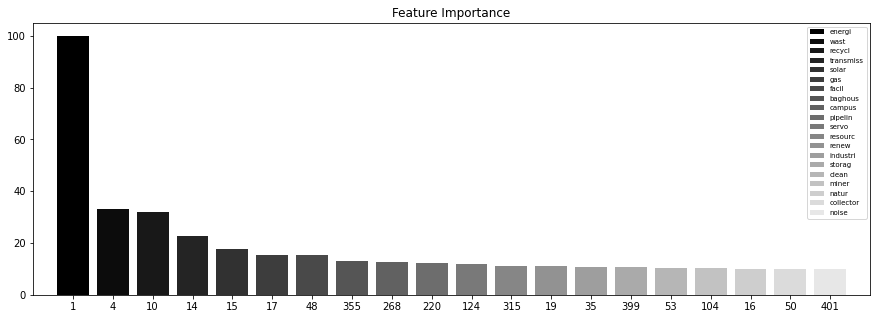

In [ ]:
features = {
    "f1": u"energi",
    "f4": u"wast",
    "f10": u"recycl",
    "f14": u"transmiss",
    "f15": u"solar",
    "f17": u"gas",
    "f48": u"facil",
    "f355": u"baghous",
    "f268": u"campus",
    "f220": u"pipelin",
    "f124": u"servo",
    "f315": u"resourc",
    "f19": u"renew",
    "f35": u"industri",
    "f399": u"storag",
    "f53": u"clean",
    "f104": u"miner",
    "f16": u"natur",
    "f50": u"collector",
    "f401": u"noise",
}

indices = np.argsort(feature_importance)[::-1]
# Plot the feature importancies 
num_to_plot = 20
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    feature_importance[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices],fontsize = 7);

In [ ]:
list_variable_RF = ["energi","recycl","wast","transmiss","solar","gas","facil","baghous","campus","pipelin","servo","resourc","renew","industri","storag","clean","miner","natur","collector",
"noise"]
X_train_not_noise_RF = X_train_noise[list_variable_RF]
X_test_not_noise_RF = X_test_noise[list_variable_RF]

In [ ]:
from sklearn.metrics import accuracy_score
import random
random.seed(7)
model_RF = RandomForestClassifier(random_state=123)
RF_GridSearch = GridSearch(X_train_not_noise_RF,Y_train,model_RF,param_grid)
Prediction_RF = RF_GridSearch.BestModelPridict(X_test_not_noise_RF)

Best: 0.797831 using {'bootstrap': False, 'max_depth': 24, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 33}


Accuray: 77.741%ROC-AUC: 0.6594
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       216
           1       0.69      0.39      0.50        85

    accuracy                           0.78       301
   macro avg       0.74      0.66      0.68       301
weighted avg       0.76      0.78      0.76       301



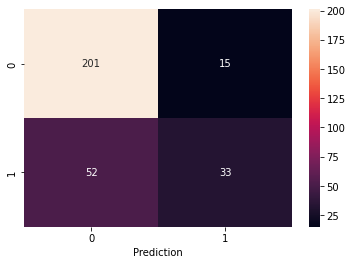

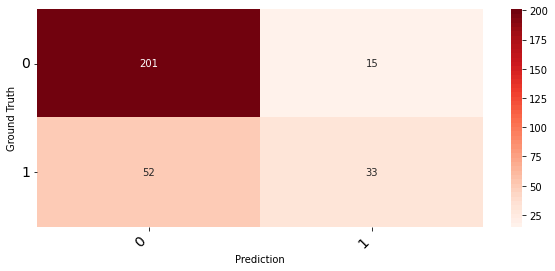

Accuray: 77.741%
ROC-AUC: 0.6594
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       216
           1       0.69      0.39      0.50        85

    accuracy                           0.78       301
   macro avg       0.74      0.66      0.68       301
weighted avg       0.76      0.78      0.76       301



In [ ]:

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_RF)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test, Prediction_RF), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test, Prediction_RF), 5)}""")
print(classification_report(Y_test, Prediction_RF))

result = classification_report(Y_test, Prediction_RF)

## XGBoost (Add noise)

In [ ]:
import random 
random.seed(7)
X_train_noise = X_train
X_test_noise = X_test

noise_train = [random.randint(0, 1) for i in range(len(X_train_noise['energi']))]
X_train_noise["noise"] = noise_train

noise_test = [random.randint(0, 1) for i in range(len(X_test_noise['energi']))]
X_test_noise["noise"] = noise_test

In [ ]:
random.seed(318)
X_train_noise_2 = X_train_noise
X_test_noise_2 = X_test_noise

noise_train = [random.randint(0, 1) for i in range(len(X_train_noise_2['energi']))]
X_train_noise["noise_2"] = noise_train

noise_test = [random.randint(0, 1) for i in range(len(X_test_noise_2['energi']))]
X_test_noise["noise_2"] = noise_test

In [ ]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300,400]
model_GB_noise = GradientBoostingClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)
GB_GridSearch = GridSearch(X_train_noise,Y_train,model_GB_noise,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test_noise)

Best: 0.808671 using {'learning_rate': 0.5, 'n_estimators': 100}


In [ ]:
model_GB = GradientBoostingClassifier(random_state=123, n_estimators=100, learning_rate=0.5)
model_GB = model_GB.fit(X_train_noise, Y_train)

In [ ]:
feature_importance = model_GB.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

print(list(X_train_noise_2.columns[sorted_idx]).index("noise"))
print(list(X_train_noise_2.columns[sorted_idx]).index("noise_2"))


379
332


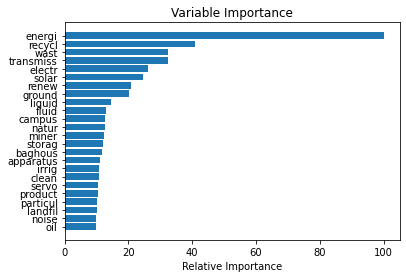

In [ ]:
pos = np.arange(sorted_idx[378:402] .shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx][378:402], align='center')
plt.yticks(pos, X_train.columns[sorted_idx][378:402])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

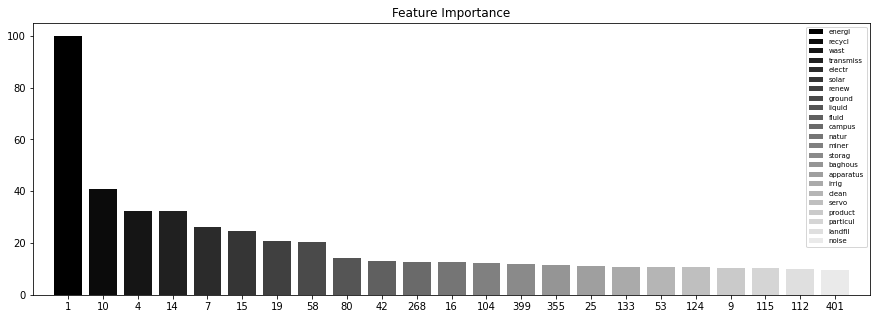

In [ ]:
features = {
    "f1": u"energi",
    "f10": u"recycl",
    "f4": u"wast",
    "f14": u"transmiss",
    "f7": u"electr",
    "f15": u"solar",
    "f19": u"renew",
    "f58": u"ground",
    "f80": u"liquid",
    "f42": u"fluid",
    "f16": u"natur",
    "f104": u"miner",
    "f268": u"campus",
    "f399": u"storag",
    "f9": u"product",
    "f355": u"baghous",
    "f25": u"apparatus",
    "f133": u"irrig",
    "f53": u"clean",
    "f124": u"servo",
    "f9": u"product",
    "f115": u"particul",
    "f112": u"landfil",
    "f401": u"noise",
}

indices = np.argsort(feature_importance)[::-1]
# Plot the feature importancies 
num_to_plot = 23
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    feature_importance[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices],fontsize = 7);

In [ ]:
list_variable = ["energi","recycl","wast","transmiss","electr","solar","renew","ground","liquid","fluid","natur","miner","campus","storag","product","baghous","apparatus",
"irrig","clean","servo","product","particul","landfil"]
X_train_not_noise = X_train[list_variable]
X_test_not_noise = X_test[list_variable]

In [ ]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300,400]
model_GB_noise = GradientBoostingClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)
GB_GridSearch = GridSearch(X_train_not_noise,Y_train,model_GB_noise,param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(X_test_not_noise)

Best: 0.800303 using {'learning_rate': 0.5, 'n_estimators': 100}


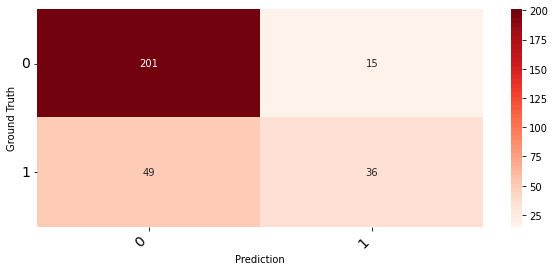

Accuray: 78.738%ROC-AUC: 0.67704
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       216
           1       0.71      0.42      0.53        85

    accuracy                           0.79       301
   macro avg       0.75      0.68      0.70       301
weighted avg       0.78      0.79      0.77       301



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test, Prediction_GB)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()



# Plot AUC, ROC
print(f'Accuray: {round(accuracy_score(Y_test, Prediction_GB), 5) * 100}%ROC-AUC: {round(roc_auc_score(Y_test, Prediction_GB), 5)}')
print(classification_report(Y_test, Prediction_GB))

## 統整

In [ ]:
result_dict = {} 
result_dict["Logistic"] = round(accuracy_score(Y_test, Prediction_LR), 5)
result_dict["SVM"] = round(accuracy_score(Y_test_svm, Prediction_svm), 5)
result_dict["RF"] = round(accuracy_score(Y_test, Prediction_RF), 5)
result_dict["XGB"] = round(accuracy_score(Y_test, Prediction_GB), 5)

result_table = pd.DataFrame(result_dict.items())
result_table.rename(columns={0: 'Model',1: 'Testing Accuracy'}, inplace=True)
result_table.sort_values(by=['Testing Accuracy'],ascending=False)

,Model,Testing Accuracy
1,SVM,0.84053
3,XGB,0.78738
2,RF,0.77741
0,Logistic,0.72757


# Modeling and Inference (Green TF-IDF with Traditional TF-IDF)

## 先把Random Search 跟 Grid Search 的 function 寫好

In [ ]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
all_text = list(df["statement_text"])

vectorizer = TfidfVectorizer(smooth_idf=True)
tfidf = vectorizer.fit_transform(all_text)
tfidf_x = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
df_y = list(df['label'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
tfidf_x

,12,24x7,3d,529,abil,abnorm,aboard,abov,abra,absorb,absorpt,abund,ac,academ,accel,acceleromet,accent,accept,access,accessori,accid,accommod,account,accumul,accur,acet,ach,achiev,acid,acoust,acoustomagnet,acquir,acquisit,across,act,action,activ,actuari,actuat,ad,...,wood,word,work,workbook,worker,workflow,workov,workshop,workspac,workstat,workwear,worldwid,worm,worn,would,woven,wrap,wreath,wreck,wrench,wringer,wrinkl,wrist,wristband,write,writer,written,wrought,wsap,wye,yarn,yo,yoghourt,yogurt,yos,zeolit,zero,zinc,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.358443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067946,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.403558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.348855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfidf_train_x, tfidf_test_x = train_test_split(tfidf_x, stratify=df["label"],test_size=0.2,random_state=22)
tfidf_train_y, tfidf_test_y = train_test_split(df_y, stratify=df["label"],test_size=0.2,random_state=22)

In [ ]:
import random 
random.seed(7)
tfidf_train_x_noise = tfidf_train_x
tfidf_test_x_noise = tfidf_test_x

noise_train = [random.uniform(0,1) for i in range(len(tfidf_train_x['energi']))]
tfidf_train_x_noise["noise"] = noise_train

noise_test = [random.uniform(0,1) for i in range(len(tfidf_test_x['energi']))]
tfidf_test_x_noise["noise"] = noise_test

In [ ]:
random.seed(318)

noise_train = [random.uniform(0,1) for i in range(len(tfidf_train_x['energi']))]
tfidf_train_x_noise["noise_2"] = noise_train

noise_test = [random.uniform(0,1) for i in range(len(tfidf_test_x['energi']))]
tfidf_test_x_noise["noise_2"] = noise_test

In [ ]:
import numpy as np 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [24,28,30]
# Minimum number of samples required to split a node
min_samples_split = [7,9,11]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.metrics import accuracy_score
random.seed(7)
model_RF = RandomForestClassifier(random_state=123)
RF_GridSearch = GridSearch(tfidf_train_x_noise, tfidf_train_y,model_RF,param_grid)
Prediction_RF = RF_GridSearch.BestModelPridict(tfidf_test_x_noise)

Best: 0.818657 using {'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 33}


## Random Forest (Add Noise)

In [ ]:
# 'bootstrap': False, 'max_depth': 24, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 56
model_RF = RandomForestClassifier(random_state=123, bootstrap=False, max_depth=24, max_features='auto', min_samples_leaf=1, min_samples_split= 7, n_estimators= 56 )
model_RF = model_RF.fit(tfidf_train_x_noise, tfidf_train_y)

In [ ]:
feature_importance = model_RF.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

print(list(tfidf_train_x_noise.columns[sorted_idx]).index("noise"))
print(list(tfidf_train_x_noise.columns[sorted_idx]).index("noise_2"))

4177
4165


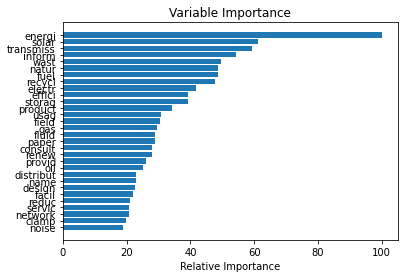

<Figure size 1440x720 with 0 Axes>

In [ ]:
pos = np.arange(sorted_idx[4177:4207] .shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx][4177:4207], align='center')
plt.yticks(pos, tfidf_train_x_noise.columns[sorted_idx][4177:4207])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(20, 10))
plt.show()

In [ ]:
tfidf_train_x_noise.columns[sorted_idx][4178:4207]

Index(['clamp', 'network', 'servic', 'reduc', 'facil', 'design', 'name',
       'distribut', 'oil', 'provid', 'renew', 'consult', 'paper', 'fluid',
       'gas', 'field', 'usag', 'product', 'storag', 'effici', 'electr',
       'recycl', 'fuel', 'natur', 'wast', 'inform', 'transmiss', 'solar',
       'energi'],
      dtype='object')

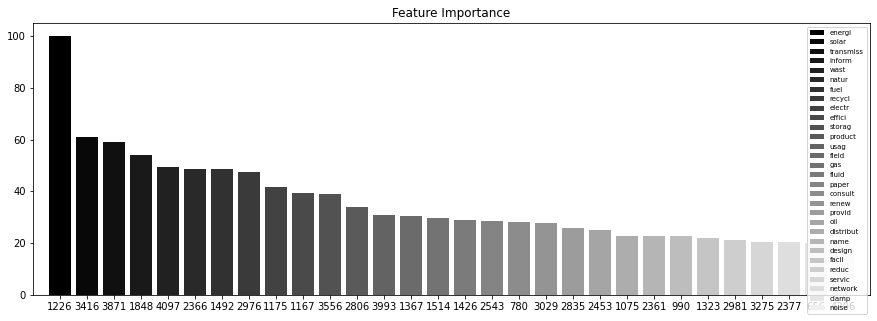

In [ ]:
features = {
    "f1226": u"energi",
    "f3416": u"solar",
    "f3871": u"transmiss",
    "f1848": u"inform",
    "f4097": u"wast",
    "f2366": u"natur",
    "f1492": u"fuel",
    "f2976": u"recycl",
    "f1175": u"electr",
    "f1167": u"effici",
    "f3556": u"storag",
    "f2806": u"product",
    "f3993": u"usag",
    "f1367": u"field",
    "f1514": u"gas",
    "f1426": u"fluid",
    "f2543": u"paper",
    "f780": u"consult",
    "f3029": u"renew",
    "f2835": u"provid",
    "f2453": u"oil",
    "f1075": u"distribut",
    "f2361": u"name",
    "f990": u"design",
    "f1323": u"facil",
    "f2981": u"reduc",
    "f3275": u"servic",
    "f2377": u"network",
    "f656": u"clamp",
    "f4206": u"noise"
}

indices = np.argsort(feature_importance)[::-1]
# Plot the feature importancies 
num_to_plot = 30
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    feature_importance[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices],fontsize = 7);

In [ ]:
list_variable_RF = tfidf_train_x_noise.columns[sorted_idx][4178:4207]
tfidf_train_x_not_noise_RF = tfidf_train_x_noise[list_variable_RF]
tfidf_test_x_not_noise_RF = tfidf_test_x_noise[list_variable_RF]

In [ ]:
from sklearn.metrics import accuracy_score
import random
random.seed(7)
model_RF = RandomForestClassifier(random_state=123)
RF_GridSearch = GridSearch(tfidf_train_x_not_noise_RF, tfidf_train_y, model_RF, param_grid)
Prediction_RF = RF_GridSearch.BestModelPridict(tfidf_test_x_not_noise_RF)

Best: 0.804573 using {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 10}


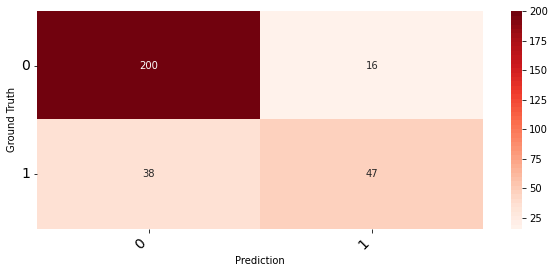

Accuray: 82.06%
ROC-AUC: 0.73943
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88       216
         1.0       0.75      0.55      0.64        85

    accuracy                           0.82       301
   macro avg       0.79      0.74      0.76       301
weighted avg       0.81      0.82      0.81       301



In [ ]:

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(tfidf_test_y, Prediction_RF)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(tfidf_test_y, Prediction_RF), 5) * 100}%
ROC-AUC: {round(roc_auc_score(tfidf_test_y, Prediction_RF), 5)}""")
print(classification_report(tfidf_test_y, Prediction_RF))

result = classification_report(tfidf_test_y, Prediction_RF)

## SVM

In [ ]:
tfidf_train_x, tfidf_test_x = train_test_split(tfidf_x, stratify=df["label"],test_size=0.2,random_state=22)
tfidf_train_y, tfidf_test_y = train_test_split(df_y, stratify=df["label"],test_size=0.2,random_state=22)

In [ ]:
tfidf_train_y = np.array(tfidf_train_y)
tfidf_test_y = np.array(tfidf_test_y)

In [ ]:
Y_train_svm = np.where(tfidf_train_y <= 0.5, -1, 1)
Y_test_svm = np.where(tfidf_test_y <= 0.5, -1, 1)
model_svm = svm.SVC()
kenel=['rbf', 'poly', 'sigmoid']
C=[0.1,1, 10, 100]
gamma=[1,0.1,0.01,0.001]
parameters=dict(kernel=kenel,C=C,gamma=gamma)
svm_GridSearch = GridSearch(tfidf_train_x,Y_train_svm,model_svm,parameters)
Prediction_svm = svm_GridSearch.BestModelPridict(tfidf_test_x)

Best: 0.827782 using {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


NameError: ignored

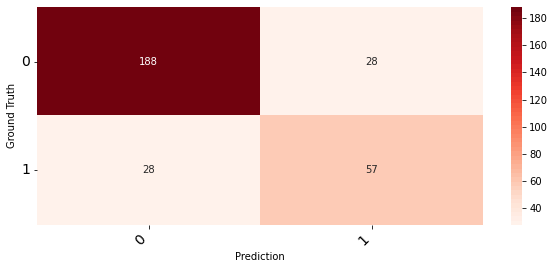

Accuray: 81.395%
ROC-AUC: 0.77048
              precision    recall  f1-score   support

          -1       0.87      0.87      0.87       216
           1       0.67      0.67      0.67        85

    accuracy                           0.81       301
   macro avg       0.77      0.77      0.77       301
weighted avg       0.81      0.81      0.81       301



In [ ]:
# Plot confusion matrix
# 'C': 100, 'gamma': 0.1, 'kernel': 'rbf'
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(Y_test_svm, Prediction_svm)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(Y_test_svm, Prediction_svm), 5) * 100}%
ROC-AUC: {round(roc_auc_score(Y_test_svm, Prediction_svm), 5)}""")
print(classification_report(Y_test_svm, Prediction_svm))


## XGBoost(Add Noise)

In [ ]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300,400]
model_GB_noise = GradientBoostingClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)
GB_GridSearch = GridSearch(tfidf_train_x_noise, tfidf_train_y, model_GB_noise, param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(tfidf_test_x_noise)

Best: 0.802018 using {'learning_rate': 0.1, 'n_estimators': 300}


In [ ]:
# 'learning_rate': 0.1, 'n_estimators': 300
model_GB = GradientBoostingClassifier(random_state=123, n_estimators=300, learning_rate=0.1)
model_GB = model_GB.fit(tfidf_train_x_noise, tfidf_train_y)

In [ ]:
feature_importance = model_GB.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

print(list(tfidf_train_x_noise.columns[sorted_idx]).index("noise"))
print(list(tfidf_train_x_noise.columns[sorted_idx]).index("noise_2"))

4194
4199


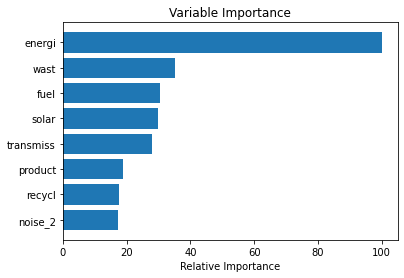

In [ ]:
pos = np.arange(sorted_idx[4199:4207] .shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx][4199:4207], align='center')
plt.yticks(pos, tfidf_train_x_noise.columns[sorted_idx][4199:4207])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

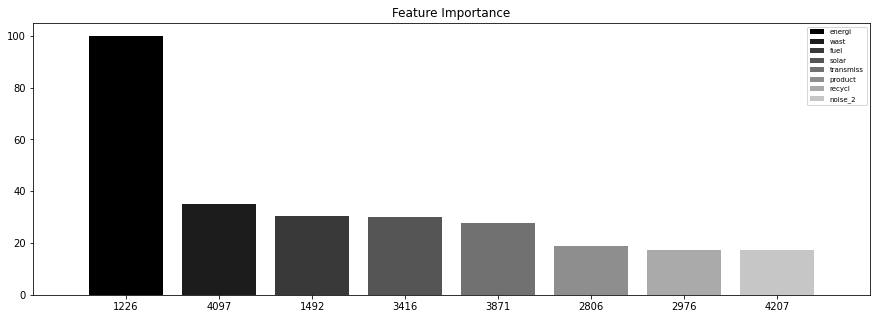

In [ ]:
features = {
    "f1226": u"energi",
    "f4097": u"wast",
    "f1492": u"fuel",
    "f3416": u"solar",
    "f3871": u"transmiss",
    "f2806": u"product",
    "f2976": u"recycl",
    "f4207": u"noise_2"
}

indices = np.argsort(feature_importance)[::-1]
# Plot the feature importancies 
num_to_plot = 8
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    feature_importance[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices],fontsize = 7);

In [ ]:
list_variable = ["energi","wast","fuel","solar","transmiss","product","recycl"]
tfidf_train_not_noise = tfidf_train_x_noise[list_variable]
tfidf_test_not_noise = tfidf_test_x_noise[list_variable]

In [ ]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300,400]
model_GB_noise = GradientBoostingClassifier(random_state=123)
param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)
GB_GridSearch = GridSearch(tfidf_train_not_noise ,tfidf_train_y, model_GB_noise, param_grid)
Prediction_GB = GB_GridSearch.BestModelPridict(tfidf_test_not_noise)

Best: 0.802858 using {'learning_rate': 0.5, 'n_estimators': 50}


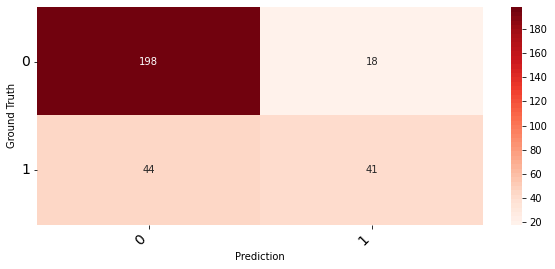

Accuray: 79.402%ROC-AUC: 0.69951
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.86       216
         1.0       0.69      0.48      0.57        85

    accuracy                           0.79       301
   macro avg       0.76      0.70      0.72       301
weighted avg       0.78      0.79      0.78       301



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(tfidf_test_y, Prediction_GB)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Plot AUC, ROC
print(f'Accuray: {round(accuracy_score(tfidf_test_y, Prediction_GB), 5) * 100}%ROC-AUC: {round(roc_auc_score(tfidf_test_y, Prediction_GB), 5)}')
print(classification_report(tfidf_test_y, Prediction_GB))

## 統整 






In [ ]:
result_dict_ti = {} 

result_dict_ti["SVM"] = round(accuracy_score(tfidf_test_y, Prediction_svm), 5) # 81.395%
result_dict_ti["XGB"] = round(accuracy_score(tfidf_test_y, Prediction_GB), 5)  # 79.402%
result_dict_ti["RF"] = round(accuracy_score(tfidf_test_y, Prediction_RF), 5)  # 82.724%

result_table_ti = pd.DataFrame(result_dict_ti.items())
result_table_ti.rename(columns={0: 'Model',1: 'Testing Accuracy'}, inplace=True)
result_table_ti.sort_values(by = 'Testing Accuracy', ascending = False)

,Model,Testing Accuracy
2,RF,0.82724
0,SVM,0.81395
1,XGB,0.79402


# Prediction Performance

## Model Comparison

### BERT Model

In [1]:
!pip3 install transformers

     |████████████████████████████████| 3.4 MB 5.5 MB/s 
     |████████████████████████████████| 61 kB 435 kB/s 
     |████████████████████████████████| 895 kB 67.5 MB/s 
     |████████████████████████████████| 3.3 MB 54.9 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [12]:
import re
import torch
import string
import numpy as np
import pandas as pd
import transformers
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from google.colab import files
#uploaded = files.upload() # If you run this on colab you need to upload the spam.csv file to colab
#import nltk
#nltk.download("stopwords")
#nltk.download("punkt") # again if your running this in colab you'll probably need to first download the stopwords set and punkt from nltk

import random 
random.seed(7)

# Loading pretrained model/tokenizer
# This is the Distilled, base, uncased version of BERT 
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

# Tokenize the sentences adding the special "[CLS]" and "[SEP]" tokens
tokenized = df["statement_text"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,max_length=168,truncation=True))

# Get the length of the longest tokenized sentence
max_len = tokenized.apply(len).max() 

# Padd the rest of the sentence with zeros if the sentence is smaller than the longest sentence
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) 

# Create the attention mask so BERT knows to ignore the zeros used for padding
attention_mask = np.where(padded != 0, 1, 0)

# Create the input tensors
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

# Pass the inputs through DistilBERT
with torch.no_grad():
    encoder_hidden_state = model(input_ids, attention_mask=attention_mask)

# Create a new dataframe with the encoded features
df_encoded = pd.DataFrame(encoder_hidden_state[0][:,0,:].numpy())

# Insert the original columns in the beginning of the encoded dataframe
#df_encoded.insert(loc=0, column='original_message', value=df["original_message"])
#df_encoded.insert(loc=0, column='spam', value=df["spam"])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
df_encoded.insert(loc=0, column='statement_text', value=df["statement_text"])
df_encoded.insert(loc=0, column='label', value=df["label"])

In [14]:
df_encoded=df_encoded.dropna()
df_encoded

,label,statement_text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.0,electr electron circuit compon natur transisto...,-0.291986,-0.120207,0.027117,-0.000552,-0.062151,-0.027557,-0.062527,-0.070618,-0.029594,-0.288377,-0.043577,-0.165937,-0.075829,0.434217,-0.175867,0.187489,0.134524,0.002823,0.181740,-0.007391,0.338001,-0.369575,0.420731,-0.161003,-0.142128,-0.136991,0.162828,-0.070419,0.109601,0.157528,-0.000859,0.270632,-0.117351,-0.403187,0.308667,-0.084777,0.175973,-0.224767,...,-0.187311,-0.203443,0.060021,0.196974,-0.120483,-0.335217,0.184782,0.073384,-0.001480,0.066137,-0.083576,0.196991,0.373902,0.260981,-0.110852,0.519265,0.154788,-0.006282,0.196445,0.111285,-0.190439,-0.012165,0.002961,0.425839,-4.281261,-0.608559,0.000824,-0.218494,-0.390766,-0.178396,0.296500,-0.413843,0.082777,-0.123048,0.110080,0.001876,-0.003141,-0.042203,0.286379,0.416252
1,0.0,electr electron circuit compon natur transisto...,-0.291986,-0.120207,0.027117,-0.000552,-0.062151,-0.027557,-0.062527,-0.070618,-0.029594,-0.288377,-0.043577,-0.165937,-0.075829,0.434217,-0.175867,0.187489,0.134524,0.002823,0.181740,-0.007391,0.338001,-0.369575,0.420731,-0.161003,-0.142128,-0.136991,0.162828,-0.070419,0.109601,0.157528,-0.000859,0.270632,-0.117351,-0.403187,0.308667,-0.084777,0.175973,-0.224767,...,-0.187311,-0.203443,0.060021,0.196974,-0.120483,-0.335217,0.184782,0.073384,-0.001480,0.066137,-0.083576,0.196991,0.373902,0.260981,-0.110852,0.519265,0.154788,-0.006282,0.196445,0.111285,-0.190439,-0.012165,0.002961,0.425839,-4.281261,-0.608559,0.000824,-0.218494,-0.390766,-0.178396,0.296500,-0.413843,0.082777,-0.123048,0.110080,0.001876,-0.003141,-0.042203,0.286379,0.416252
2,0.0,electr electron circuit activ batteri cell man...,-0.365274,-0.141498,-0.070363,-0.058312,-0.048255,-0.213004,-0.010907,-0.118216,-0.056849,-0.267073,-0.106734,-0.222290,0.034690,0.326628,-0.165084,0.225993,0.250221,0.064689,0.167329,0.133114,0.350869,-0.348082,0.414816,-0.168601,-0.096484,0.008215,0.209276,0.047648,0.151360,0.072316,-0.006772,0.219460,-0.003993,-0.288687,0.408135,-0.009240,0.135891,-0.217353,...,-0.054153,-0.386782,0.111416,0.125802,-0.320444,-0.346326,0.104476,-0.024944,-0.075533,-0.001039,-0.220171,0.223349,0.230210,0.297428,-0.096279,0.434513,0.103782,0.018519,0.362003,0.235638,-0.137170,0.093818,-0.287622,0.385671,-4.222392,-0.475804,-0.058881,-0.140233,-0.260915,-0.158819,0.279882,-0.324793,0.105001,-0.052082,0.152498,-0.038595,-0.123610,-0.132213,0.373555,0.124913
3,0.0,electr electron circuit electr electron compon...,-0.278028,-0.109334,-0.000372,-0.063749,-0.138763,0.015854,-0.080319,-0.176752,-0.088557,-0.290065,-0.076246,-0.100726,-0.035868,0.401535,-0.130144,0.169666,0.159769,-0.033737,0.152001,0.068065,0.303161,-0.319440,0.360908,-0.155575,-0.043699,-0.039976,0.166384,-0.012965,0.155248,0.137859,-0.013230,0.175262,-0.001271,-0.430605,0.369880,-0.145632,0.176793,-0.331981,...,-0.060565,-0.245501,0.104318,0.184342,-0.204574,-0.322736,0.211995,-0.004704,-0.031740,-0.052606,-0.153683,0.287925,0.267078,0.257955,-0.117940,0.473084,0.212338,-0.058086,0.207222,0.240054,-0.165795,-0.000803,-0.021683,0.408533,-4.375746,-0.528398,-0.032598,-0.182708,-0.410506,-0.151042,0.260581,-0.380379,0.064412,-0.073777,0.179207,-0.036901,-0.103676,-0.015754,0.274611,0.331985
4,0.0,housewar name bowl cup dish heat insul vessel ...,-0.305728,-0.137355,0.040266,-0.012516,-0.048780,-0.028183,0.115687,0.061688,-0.201213,-0.161949,-0.077240,-0.227166,0.127093,0.479835,-0.061037,0.076170,0.053239,0.440858,0.278625,0.239224,0.236736,-0.652513,0.223219,-0.184106,0.062749,0.066756,-0.026675,-0.008781,0.102223,0.184066,-0.091702,0.409662,0.097798,-0.509500,0.260031,-0.161606,0.319763,-0.104458,...,-0.125138,-0.218549,0.326513,0.149876,-0.210687,-0.308459,0.00302

In [15]:
# Initialize StandardScaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

# Dont standerdize binary columns and the text column
feats_to_scale = df_encoded.drop(["label", "statement_text"], axis=1)

# Create a new dataframe with the standardized features
scaled_features = pd.DataFrame(scaler.fit_transform(feats_to_scale))

# Update the dataset with the new standerdized features
scaled_df = df_encoded.copy()
scaled_df.update(scaled_features)

In [16]:
X = scaled_df.drop(["label", "statement_text"], axis=1)
y = scaled_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state=22)

In [17]:

from keras.models import Sequential
from keras.layers import Dropout, Dense, BatchNormalization
model = Sequential()

model.add(Dense(1000, input_shape=(768,), activation="relu"))
model.add(BatchNormalization(axis=-1))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(10, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

In [18]:
# defining the learning rate, the number of epochs and the batch size
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
INIT_LR = 0.001
NUM_EPOCHS = 30
BS = 256
opt = RMSprop(lr = INIT_LR)

# This is just a necessary step to compile the model, we don't actually need it because we're not using the old model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# Reduce the learning rate by half if validation accuracy has not increased in the last 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

fitted_network = model.fit(X_train, y_train, validation_split=0.2, batch_size=BS, epochs=NUM_EPOCHS, callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/30
4/4 [==============================] - 3s 189ms/step - loss: 0.8963 - accuracy: 0.5833 - val_loss: 0.7253 - val_accuracy: 0.5477 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - 0s 62ms/step - loss: 0.7333 - accuracy: 0.6281 - val_loss: 0.6547 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - 0s 56ms/step - loss: 0.6424 - accuracy: 0.6938 - val_loss: 0.6822 - val_accuracy: 0.6349 - lr: 0.0010
Epoch 4/30
4/4 [==============================] - 0s 58ms/step - loss: 0.5668 - accuracy: 0.7156 - val_loss: 0.6372 - val_accuracy: 0.6805 - lr: 0.0010
Epoch 5/30
4/4 [==============================] - 0s 59ms/step - loss: 0.5496 - accuracy: 0.7437 - val_loss: 0.6423 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 6/30
4/4 [==============================] - 0s 63ms/step - loss: 0.4890 - accuracy: 0.7792 - val_loss: 0.6300 - val_accuracy: 0.7054 - lr: 0.0010
Epoch 7/30
4/4 [==============================] - 0s 61ms/step - loss: 0.4259 - accurac

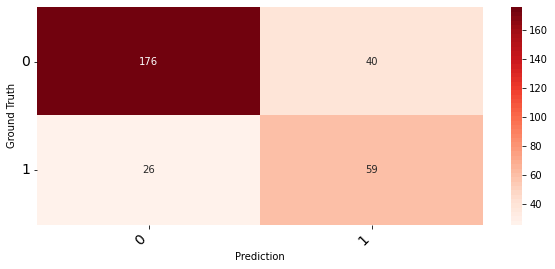

Accuray: 78.07300000000001%
ROC-AUC: 0.75447
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       216
         1.0       0.60      0.69      0.64        85

    accuracy                           0.78       301
   macro avg       0.73      0.75      0.74       301
weighted avg       0.79      0.78      0.79       301



In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
# predict results
preds = np.round(model.predict(X_test)).flatten()

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5)}""")
print(classification_report(y_test, preds))

### Word2Vector Model




In [17]:
df = pd.read_excel('/content/drive/My Drive/統計學習期末/green_trademark_label.xlsx')
df=df[["Green_TM_Label","statement_text"]]
df=df.dropna()
df=df.rename(columns={'Green_TM_Label': 'label'}) 
df["category"]=df['label']
map_dict = {1: "Green", 0:"non_Green"}
df['category'].replace(map_dict, inplace=True)

!pip install text-hammer
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import random
random.seed(7)

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
#     df[column] = df[column].progress_apply(lambda x:th.spelling_correction(x))
  
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

cleaned_df = text_preprocessing(df, "statement_text")


from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(cleaned_df.statement_text, cleaned_df.label, test_size = 0.2, stratify = cleaned_df.label
                                                 ,random_state = 22)
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=500,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 500, padding = 'post')

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

  0%|          | 0/1503 [00:00<?, ?it/s]

In [15]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

In [18]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') # this would download vector with 100 dimension

[==================================================] 100.0% 128.1/128.1MB downloaded


In [19]:
glove_gensim['cat'].shape[0] # this is the diemnsion of the vectors

100

In [20]:

# now lets connvert all the words we have in our data into vectors 
vector_size = 100
gensim_weight_matrix = np.zeros((10000 ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < 10000: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

# designing our architecture 
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = 10000,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model_gensim.add(Dense(1, activation = 'sigmoid'))
model_gensim.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')


from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 35, batch_size = 120, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )

model_gensim.evaluate(X_test_pad, y_test) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Epoch 1/35
11/11 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.6797
Epoch 00001: val_accuracy improved from -inf to 0.75083, saving model to ./model_gensim.h5
11/11 [==============================] - 24s 1s/step - loss: 0.6029 - accuracy: 0.6797 - val_loss: 0.5535 - val_accuracy: 0.7508
Epoch 2/35
11/11 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.7396
Epoch 00002: val_accuracy did not improve from 0.75083
11/11 [==============================] - 10s 896ms/step - loss: 0.5803 - accuracy: 0.7396 - val_loss: 0.5427 - val_accuracy: 0.7276
Epoch 3/35
11/11 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.7454
Epoch 00003: val_accuracy improved from 0.75083 to 0.75748, saving model to ./model_gensim.h5
11/11 [==============================] - 10s 907ms/step - loss: 0.5292 - accuracy: 0.7454 - val_loss: 0.5275 - val_accuracy: 0.7575
Epoch 4/35
11/11 [==============================] - ETA: 0s - loss: 0.5052 - accuracy

[0.5419485569000244, 0.7807309031486511]

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       262
           1       0.34      0.74      0.47        39

    accuracy                           0.78       301
   macro avg       0.65      0.76      0.66       301
weighted avg       0.87      0.78      0.81       301



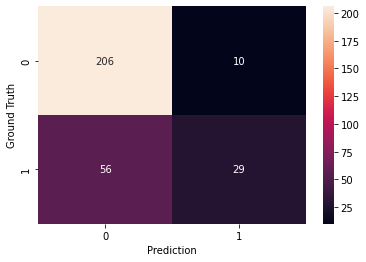

Accuray: 78.07300000000001%
ROC-AUC: 0.64744


In [21]:
from sklearn import metrics
y_pred_gensim = np.where(model_gensim.predict(X_test_pad)>0.5,1,0)
print(metrics.classification_report(y_pred_gensim, y_test))

# Plot confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_gensim)
cm
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, y_pred_gensim), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, y_pred_gensim), 5)}""")

## Performance

### Performance ( Modified TF-IDF Method )

In [ ]:
result_table

,Model,Testing Accuracy
0,Logistic,0.72757
1,SVM,0.84053
2,RF,0.77741
3,XGB,0.78738


### Performance ( Traditional TF-IDF Method )

In [ ]:
result_table_ti

,Model,Testing Accuracy
0,SVM,0.81395
1,XGB,0.79402
2,RF,0.82724


# Visualization of results

輸入已經先預處理過的文字的要預測的資料(2014-2020所有的trademark)

In [ ]:
#def preprocess(text):
    # Remove stopwords
    #stopwords_list = stopwords.words('english')
    #words = [i for i in text.split() if i.lower() not in stopwords_list]
    #text_1 = ' '.join(words)
    # Remove puctuation and replace with a space.
    #punc_string = string.punctuation
    #text_2 = text_1.translate(str.maketrans(punc_string, len(punc_string)*' '))
    #words_1 = text_2.split()
    # Perform word stemming 
    #stemmer = SnowballStemmer('english')
    #words_2 = [stemmer.stem(word) for word in words_1]
    #text_3 = ' '.join(words_2)
    #return text_3

#處理文字
#nltk.download('stopwords')
#df_testing["statement_text"] = df_testing["statement_text"].apply(preprocess)
#df_testing["statement_text"] = df_testing["statement_text"].apply(preprocess)

In [ ]:
import pandas as pd
df_time_series = pd.read_csv('/content/drive/My Drive/統計學習期末/GTM_series.csv')
df_testing=df_time_series[["statement_text"]]

主方法 : Green TF-IDF Method \
最好的classifier : SVM

In [ ]:
X_testing_svm = raw2feature_vis(df_testing,keyword_dict)
model_svm = svm.SVC(C=10, gamma= 0.1, kernel= 'rbf')
Y_train_svm = np.where(Y_train <= 0.5, -1, 1)
model_svm.fit(X_train.iloc[:,0:400],Y_train_svm)
X_testing_svm.columns = keyword_dict.keys()
Prediction_svm_vis = model_svm.predict(X_testing_svm)
Prediction_svm_vis = np.where(Prediction_svm_vis <= 0.5, 0, 1)

In [ ]:
df_pred = pd.DataFrame(Prediction_svm_vis)
df_pred.rename(columns={0: 'Prediction'}, inplace=True)
df_final=pd.merge(df_pred,df_time_series, left_index=True, right_index=True)[['registration_dt','serial_no','Prediction','statement_type_cd']]

In [ ]:
from datetime import *
df_final=df_final[df_final['Prediction']==1].drop_duplicates(subset=['serial_no'])
df_final['registration_dt'] = df_final['registration_dt'].map(lambda x : datetime.strptime(x,"%Y-%m-%d"))
df_final['registration_dt'] = df_final['registration_dt'].map(lambda x : x.year)
df_final=df_final[['registration_dt','Prediction']].groupby('registration_dt').sum()

In [ ]:
df_final

,Prediction
registration_dt,
2014,9566
2015,10427
2016,11820
2017,13561
2018,15362
2019,17784
2020,14243


Text(0, 0.5, '# of GTM')

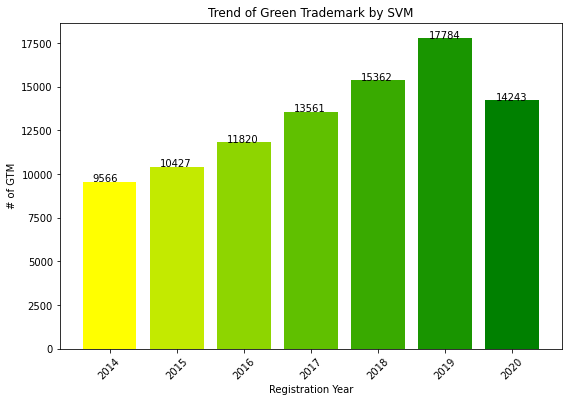

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
# Variables
!pip install colour
from colour import Color
index = df_final.index
values = df_final['Prediction']
red = Color("yellow")
colors = list(red.range_to(Color("green"),7))
colors = [color.rgb for color in colors]
plt.figure(figsize=(9,6))
 
plt.bar(x=index,
 
        height=values,
 
        color=colors)
 
plt.xticks(rotation=45)
for i, v in enumerate(values):
    plt.text(index[i] - 0.25, v + 0.01, str(v))

plt.title("Trend of Green Trademark by SVM") 
plt.xlabel('Registration Year')  
plt.ylabel('# of GTM') 